<a href="https://colab.research.google.com/github/perlitz/VAE_talk/blob/master/MNIST_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
#!pip install ipdb
# import ipdb

In [0]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import PIL
import torch.nn.functional as F

plt.ion()   # interactive mode

set_seed = 1
torch.manual_seed(set_seed);

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Gathering data and dataloader

In [0]:
batch_size_train = 64
batch_size_test  = 1000
n_epochs = 3
log_interval = 100

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

## Define the network

In [0]:
class Net(nn.Module):
  
  def __init__(self):
    """This is where I will define the layers I use"""
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=1 , out_channels=10, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()

    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50 , 10)


  def forward(self, x):
    """This is where the forward pass is defined"""
    # ipdb.set_trace()
    
    x = F.relu6(F.max_pool2d(self.conv1(x),2))
    x = F.relu6(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))

    x = x.view(-1, 320)

    x = self.fc2(F.dropout(self.fc1(x), training=self.training))
    
    return F.log_softmax(x)

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):

  net.train() # put the network in to training mode  

  for batch_idx , (data, label) in enumerate(train_loader): # loop over examples

    optimizer.zero_grad() # nullify the gradients
    # run data trough the net
    predicted_label = net.forward(data.to(device))
    # evaluate the loss
    loss = F.nll_loss(predicted_label, label.to(device))
    # backpropagate
    loss.backward()
    # fix weights using the optimizer
    optimizer.step()

    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
         epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

def test():
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, label in test_loader:

      output = net(data.to(device))
      test_loss += F.nll_loss(output, label.to(device), size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq((label.to(device)).data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [107]:
net = Net().to(device)
optimizer = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.5)

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3481, Accuracy: 812/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346265
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.327557
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.773395
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.752343
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.663879
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.504188
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.395553
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.284800
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.351575
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.410991

Test set: Avg. loss: 0.1721, Accuracy: 9476/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.249018
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.337466
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.234552
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.374963
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.162060
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.515217
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.158243
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.22622

Text(0, 0.5, 'negative log likelihood loss')

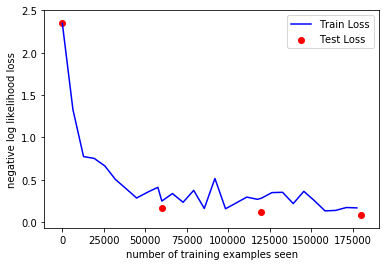

In [108]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')